# Environment and Imports

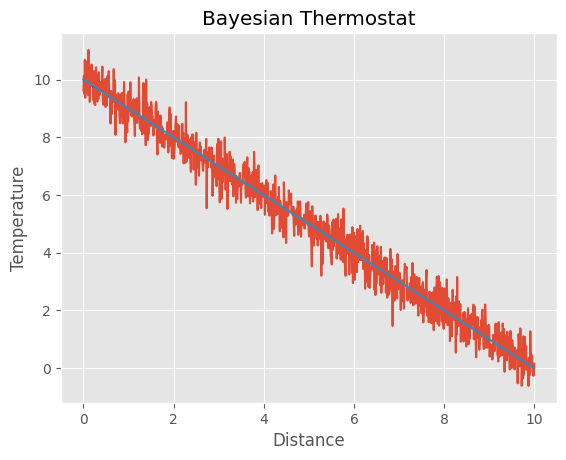

In [54]:
import numpy as np
from scipy.stats import norm 
import matplotlib.pyplot as plt

plt.style.use('ggplot')

num_samples     = 1000
distance_range  = 10
distances       = np.linspace(0, distance_range, num_samples)
noise           = np.random.normal(loc=0, scale=1/2, size=num_samples)

y       = - distances + 10
noisy_y = y + noise

plt.title('Bayesian Thermostat')
plt.ylabel('Temperature')
plt.xlabel('Distance')
plt.plot(distances, noisy_y, zorder=1)
plt.plot(distances, y, zorder=2)
plt.show()

# Perception

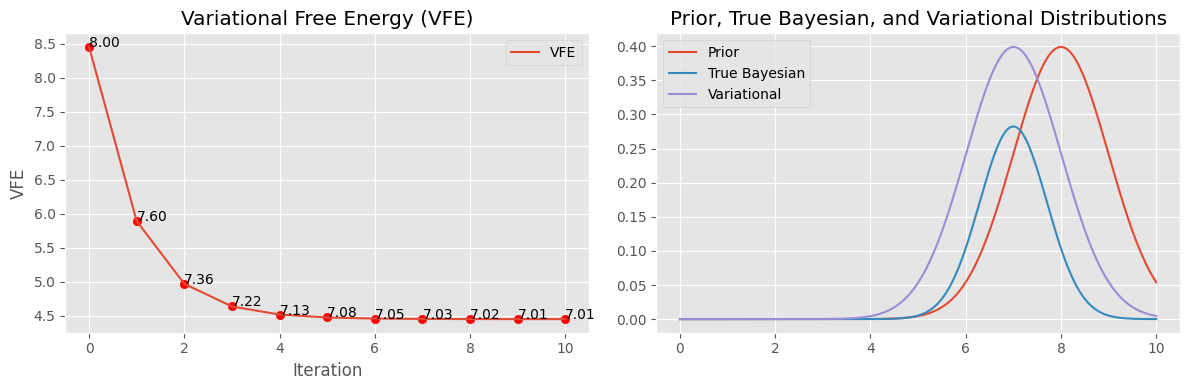

In [55]:
# Define functions
def f(x):
    return -x + 10

def df(x):
    return np.full_like(x, -1)

def calculate_ex(phi, prior, sigma_y):
    return (phi - prior) / sigma_y

def calculate_ey(y, phi, sigma_x):
    return (y - f(phi)) / sigma_x

# Parameters
inference_iterations = 10
prior = 8
sigma_y = 1/2
sigma_x = 1/2
y_sample = 4

# Initialize lists for phi estimates and variational free energies (VFEs)
phi_estimates = [prior]
vfes = []

# Iteratively update phi estimates and calculate VFEs
for i in range(inference_iterations):
    error_y = calculate_ey(y_sample, phi_estimates[-1], sigma_x)
    error_x = calculate_ex(phi_estimates[-1], prior, sigma_y)

    vfes.append(1 / 2 * (error_y**2 + error_x**2 + np.log(2 * np.pi * sigma_x**2) + np.log(2 * np.pi * sigma_y**2)))
    phi_estimates.append(phi_estimates[-1] + 0.1 * (error_y * df(phi_estimates[-1]) - error_x))

vfes.append(1 / 2 * (error_y**2 + error_x**2 + np.log(2 * np.pi * sigma_x**2) + np.log(2 * np.pi * sigma_y**2)))

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# First plot: VFE
axs[0].plot(vfes, label='VFE')
axs[0].scatter(range(len(vfes)), vfes, color='red')
axs[0].legend()

# Add labels to points in the VFE plot with phi_estimates rounded to 2 decimal places
for i, (x, vfe) in enumerate(zip(range(len(vfes)), vfes)):
    axs[0].text(x, vfe, f'{phi_estimates[i]:.2f}', fontsize=10, ha='left')

axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("VFE")
axs[0].set_title("Variational Free Energy (VFE)")
axs[0].grid(True)

# Second plot: Prior, True Bayesian, and Variational distributions
phi = phi_estimates[-1]
numerator = np.multiply(norm.pdf(y_sample, loc=f(distances), scale=1), norm.pdf(distances, loc=prior, scale=1))
normalization = sum(numerator * 0.02)

axs[1].plot(distances, norm.pdf(distances, loc=prior, scale=1), label='Prior')
axs[1].plot(distances, numerator / normalization, label='True Bayesian')
axs[1].plot(distances, norm.pdf(distances, loc=phi, scale=1), label='Variational')

axs[1].set_title("Prior, True Bayesian, and Variational Distributions")
axs[1].legend()

# Show the plot
plt.tight_layout()
plt.show()


# Learning

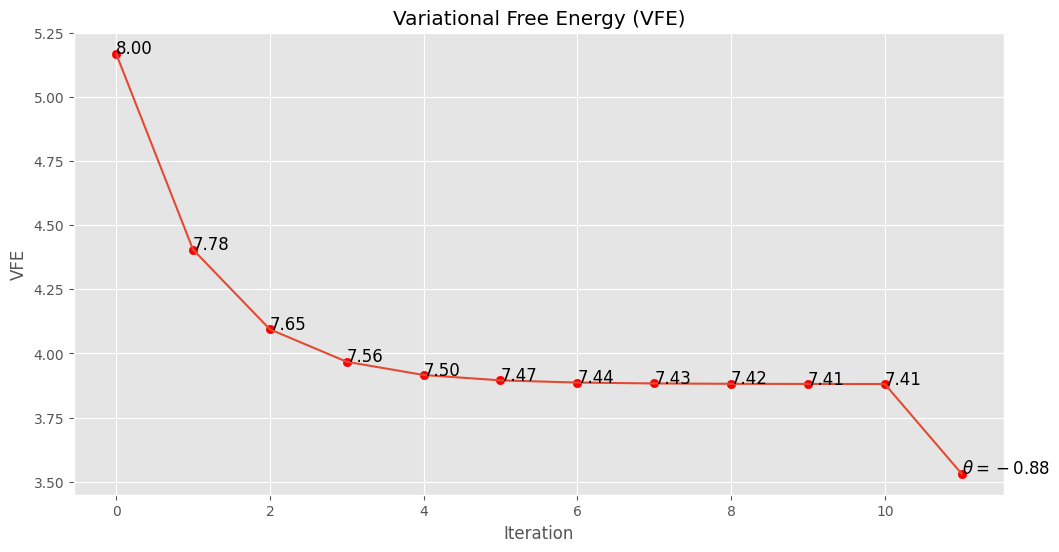

In [56]:
def f(x, theta):
    return theta * x + 10

def df_dtheta(x, theta):
    return x

def df_dx(x, theta):
    return theta

def calculate_ex(phi, prior , sigma_y):
    return (phi - prior) / sigma_y

def calculate_ey(y, phi, theta, sigma_x):
    return (y - f(phi, theta)) / sigma_x

def calculate_vfe(error_y, error_x, sigma_y, sigma_x):
    return 1 / 2 * (error_y**2 + error_x**2) + np.log(2 * np.pi * sigma_x) + np.log(2 * np.pi * sigma_y)

# Parameters
inference_iterations = 10
prior = 8
sigma_y = 1/2
sigma_x = 1/2
y_sample = 4

theta = -0.9
eta   = 0.01 # Learning rate

# Initialize lists for phi estimates and variational free energies (VFEs)
phi_estimates = [prior]

vfes = []

# Iteratively update phi estimates and calculate VFEs
for i in range(inference_iterations):

    error_y = calculate_ey(y_sample, phi_estimates[-1], theta, sigma_y)
    error_x = calculate_ex(phi_estimates[-1], prior, sigma_x)

    vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

    phi_estimates.append(phi_estimates[-1] + 0.1 * ( error_y * df_dx(phi_estimates[-1], theta) - error_x))

error_y = calculate_ey(y_sample, phi_estimates[-1], theta, sigma_y)
error_x = calculate_ex(phi_estimates[-1], prior, sigma_x)

vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

# Plot the VFE plot
plt.figure(figsize=(12, 6))
plt.scatter(range(len(vfes)), vfes, color='red')

# Add labels to points in the VFE plot with phi_estimates rounded to 2 decimal places
for i, (x, vfe) in enumerate(zip(range(len(vfes)), vfes)):
    plt.text(x, vfe, f'{phi_estimates[i]:.2f}', fontsize=12, ha='left')

# After convergence - update theta estimate

theta = theta + 0.1 * eta * (error_y / sigma_y) * df_dtheta(phi_estimates[-1], theta)

error_y = calculate_ey(y_sample, phi_estimates[-1], theta, sigma_y)
error_x = calculate_ex(phi_estimates[-1], prior, sigma_x)

vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

plt.scatter(len(vfes) - 1, vfes[-1], color='red')
plt.text(len(vfes) - 1, vfes[-1], rf'$\theta = {theta:.2f}$', fontsize=12, ha='left')

plt.plot(vfes, label='VFE')

plt.title("Variational Free Energy (VFE)")
plt.xlabel("Iteration")
plt.ylabel("VFE")
plt.grid(True)
plt.show()


# Action

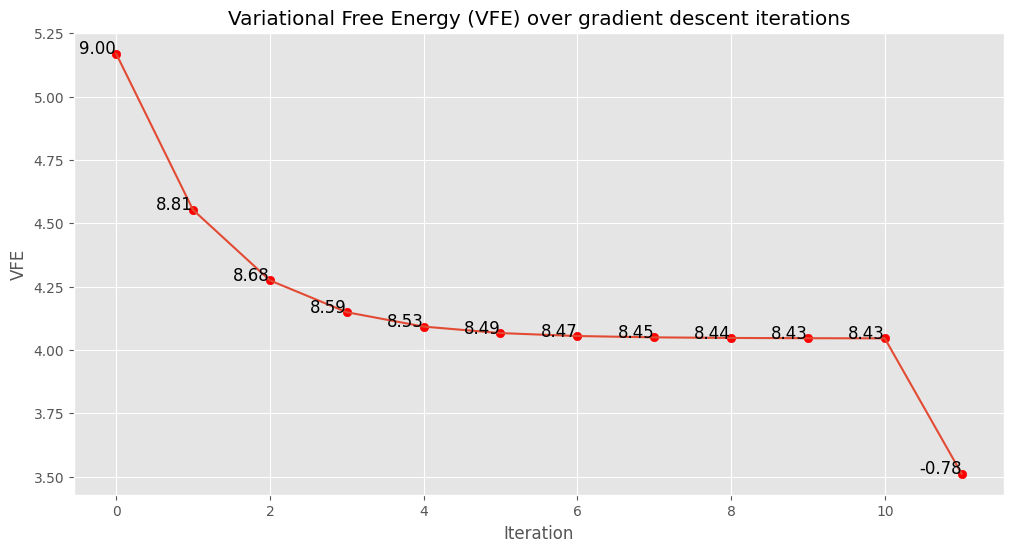

In [57]:
def f(x, theta):
    return theta * x + 10

def df_dtheta(x, theta):
    return x

def df_dx(x, theta):
    return theta

def calculate_ex(phi, prior , sigma_y):
    return (phi - prior) / sigma_y

def calculate_ey(y, phi, theta, sigma_x):
    return (y - f(phi, theta)) / sigma_x

def calculate_vfe(error_y, error_x, sigma_y, sigma_x):
    return 1 / 2 * (error_y**2 + error_x**2) + np.log(2 * np.pi * sigma_x) + np.log(2 * np.pi * sigma_y)

# Parameters
inference_iterations = 10
prior = 9
sigma_y = 1/2
sigma_x = 1/2
y_sample = 4

biased_mean = 4

theta = -0.8
eta   = 0.01 # Learning rate

# Initialize lists for phi estimates and variational free energies (VFEs)
phi_estimates = [prior]

vfes = []

# Iteratively update phi estimates and calculate VFEs
for i in range(inference_iterations):

    error_y = calculate_ey(y_sample, phi_estimates[-1], theta, sigma_y)
    error_x = calculate_ex(phi_estimates[-1], prior, sigma_x)

    vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

    phi_estimates.append(phi_estimates[-1] + 0.1 * ( error_y * df_dx(phi_estimates[-1], theta) - error_x))

error_y = calculate_ey(y_sample, phi_estimates[-1], theta, sigma_y)
error_x = calculate_ex(phi_estimates[-1], prior, sigma_x)

vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

# After convergence - update theta estimate

theta = theta + 0.1 * eta * (error_y / sigma_y) * df_dtheta(phi_estimates[-1], theta)

error_y = calculate_ey(y_sample, phi_estimates[-1], theta, sigma_y)
error_x = calculate_ex(phi_estimates[-1], prior, sigma_x)

vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

phi_estimates.append(theta)

# Plot the VFE plot
plt.figure(figsize=(12, 6))
plt.plot(vfes, label='VFE')
plt.scatter(range(len(vfes)), vfes, color='red')

# Add labels to points in the VFE plot with phi_estimates rounded to 2 decimal places
for i, (x, vfe) in enumerate(zip(range(len(vfes)), vfes)):
    plt.text(x, vfe, f'{phi_estimates[i]:.2f}', fontsize=12, ha='right')

plt.title("Variational Free Energy (VFE) over gradient descent iterations")
plt.xlabel("Iteration")
plt.ylabel("VFE")
plt.grid(True)
plt.show()


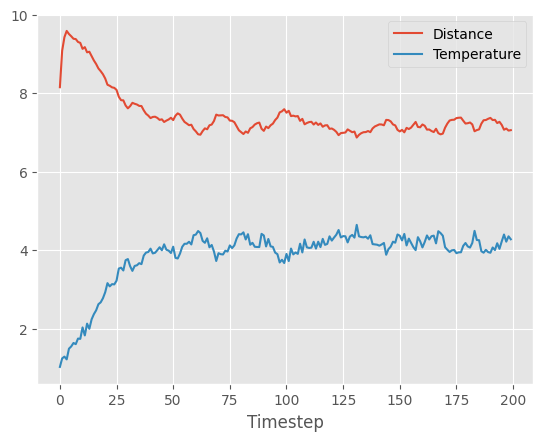

In [58]:

class BayesianThermostat:

    controls = ["STAY", "LEFT", "RIGHT"]

    def __init__(
            self,
            init_distance = 9,
            step_size = 0.1,
            variance=1/100
        ):
        self.init_distance = init_distance
        self.agent_distance = init_distance
        self.step_size = step_size
        self.variance = variance

    def _f(self, distance):
        return - distance + 10
    
    def generate_observation(self):
        return np.random.normal(self._f(self.agent_distance), np.sqrt(self.variance))

    def step(self, action):

        # Move agent

        if self.controls[action] == "STAY":
            pass

        elif self.controls[action] == "LEFT":
            self.agent_distance = max(0, self.agent_distance - self.step_size)

        elif self.controls[action] == "RIGHT":
            self.agent_distance = min(10, self.agent_distance + self.step_size)
        else:
            raise Exception("Invalid Action Selection")
        
        # Generate new observation

        return self.generate_observation()

    def reset(self):
        self.agent_distance = self.init_distance
        return self.generate_observation()

# Agent

class PCAgent:

    controls = ["STAY", "LEFT", "RIGHT"]

    def __init__(
            self, 
            inference_iterations = 10,
            prior = 6,
            var_y = 1/16,
            var_x = 1/16,
            biased_mean = 4,
            theta=-0.75,
            eta=0.01,
            env_step_size=0.1
        ):

        self.inference_iterations   = inference_iterations
        self.var_y                  = var_y
        self.var_x                  = var_x
        self.biased_mean            = biased_mean
        self.theta                  = theta
        self.eta                    = eta
        self.env_step_size          = env_step_size

        self.x                      = prior

    def f(self, x, theta):
        return self.theta * x + 10

    def df_dtheta(self, x, theta):
        return x

    def df_dx(self, x, theta):
        return self.theta

    def calculate_ex(self, phi, prior):
        return (phi - prior) / np.sqrt(self.var_y)

    def calculate_ey(self, y, phi):
        return (y - self.f(phi, self.theta)) / np.sqrt(self.var_x)

    def calculate_vfe(self, error_y, error_x):
        return 1 / 2 * (error_y**2 + error_x**2) + np.log(2 * np.pi * np.sqrt(self.var_x)) + np.log(2 * np.pi * np.sqrt(self.var_y))
    
    def perceive(self, y):

        phi_estimates   = [self.x]
        # vfes            = []

        for i in range(self.inference_iterations):

            error_y = self.calculate_ey(y, phi_estimates[-1])
            error_x = self.calculate_ex(phi_estimates[-1], self.x)

            # vfes.append(calculate_vfe(error_y, error_x))

            phi_estimates.append(phi_estimates[-1] + 0.2 * ( error_y * self.df_dx(phi_estimates[-1], self.theta) - error_x))

        # error_y = self.calculate_ey(y, phi_estimates[-1])
        # error_x = self.calculate_ex(phi_estimates[-1], self.x)

        # vfes.append(calculate_vfe(error_y, error_x, sigma_y, sigma_x))

        self.x = phi_estimates[-1]

        # print("self.x", self.x)

    def learn(self, y):

        error_y = self.calculate_ey(y, self.x)

        self.theta = self.theta + 0.1 * self.eta * error_y * self.df_dtheta(self.x, self.theta)

        # print("self.theta", self.theta)

    def act(self):

        efes = []

        for u in self.controls:

            # Predict next latent state given action

            if u == "STAY":
                pred_next_x = self.x

            elif u == "LEFT":
                pred_next_x = self.x - self.env_step_size

            elif u == "RIGHT":
                pred_next_x = self.x + self.env_step_size

            # Predict the observations given the predicted next state

            pred_next_y = self.f(pred_next_x, self.theta)

            entropy         = (1 / 2 ) * ( np.log(2 * np.pi * self.var_y + 1) )
            kl_divergence   = np.log(np.sqrt(self.var_y) / np.sqrt(self.var_y)) + (self.var_y + (self.biased_mean - pred_next_y)**2) / (2 * self.var_y) - 0.5

            efes.append(entropy + kl_divergence)

        efes = np.array(efes)

        efe_dist = np.exp(- efes )/sum(np.exp(- efes))

        u = np.random.choice(self.controls, p=efe_dist)

        return self.controls.index(u)


env = BayesianThermostat()
agent = PCAgent()
y = env.reset()

xs = []
ys = []

for _ in range(200):

    agent.perceive(y)
    agent.learn(y)

    xs.append(agent.x)
    ys.append(y)
    
    u = agent.act()

    y = env.step(u)


plt.plot(xs, label='Distance')
plt.plot(ys, label='Temperature')

plt.xlabel("Timestep")
plt.legend()
plt.show()